In [ ]:
from IPython.display import Image, display
Image("ryoko.png", width="70")

# Message from Dr. Ryoko
"*Hi! I hope you now understand how the Lights Out puzzle works.<br/>The floor of the room I must cross has 3 x 3 tiles. Each tile is made of a single qubit.<br/>
Some of these qubits fluctuate between the ground state and the excited state. <br/> I have been observing their behavior and noticed that there is a pattern - the floor can only be in either one of the four patterns as shown in each of the examples below. <br/>
Due to decoherence, there is not enough time to play around with the switches.<br/> You need to find out which board can be cleared with three switch operations. Good luck!*"<br/>

Jump to [solution](#Solution)...

# Week2-B: Four-Lights Out
In this problem, we are dealing with multiple binary data at the same time. 
We have to determine if each of the given four Lights Out boards are solvable under the given constraints, so let's devise a quantum circuit to solve them all at the same time.

As an example, let's consider how to find a board that can be cleared with just a single switch operation from the 4 boards given below. The initial state of the 4 boards is given in the following two-dimensional array, where "0" and "1" represent "off" and "on" respectively similar to the previous learning problem:

lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

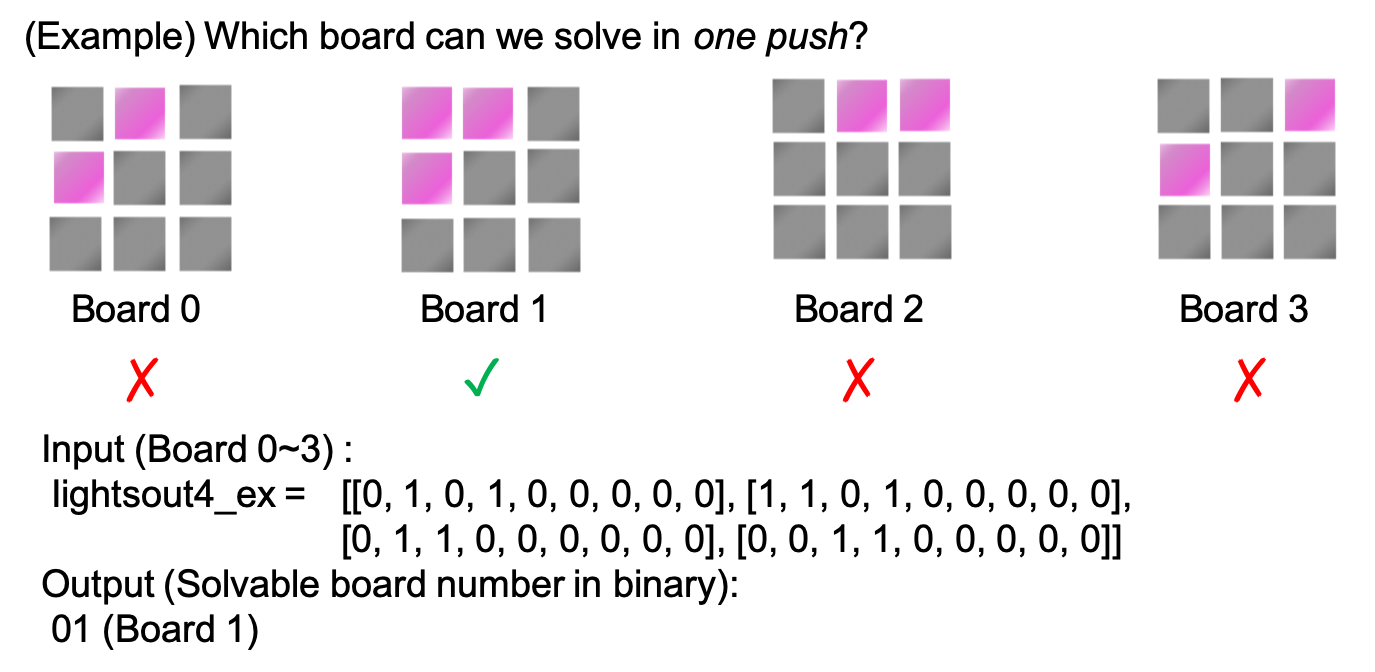

In [2]:
from IPython.display import Image, display
Image('4lightsout_ex.png')

## Answer Strategy
If only one board is given, this is a decision problem.
Using the algorithm from the first Lights Out puzzle (2A), you can solve this problem by counting the "1"s in the output.
 
If we are given multiple boards, there will be several approaches.
1. Iterate the same "one board algorithm" for each board.
2. Hold information for multiple boards at the same time and solve the problems in a single run (execute the algorithm once). 
- For the rest of this document, we discuss how to use the latter approach to solve this type of problem.

First, how do we keep data for all the boards at the same time?
1. Naive data structures:　　9 Qubits/board * 4 boards > 32 qubits (Upper limit of ibm_qasm_simulator).
2. Prepare the  superposition state:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - The circuit configuration used for state generation is non-trivial.
3. *qRAM* is known as one solution. 
    - **Pros**: Intuitive implementation. 
    - **Cons**: Computationally expensive. 

Of course you can devise and adopt other smart ways to do this.

Here, we will focus on *qRAM* and describe its configuration and implementation.

In [1]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## qRAM: Quantum Random Access Memory

In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, **address qubits $a$** have the $N$-addresses as superposition and the corresponding binary data is stored in **data qubits $d$** as a state vector.
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　
We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

## Example: Find the data from qRAM
Prepare a qRAM of $n$-addresses in which the numbers $k_0, k_1, .. , k_{n-1}$ are stored in this order.  
Find the address in which the number $m$ is stored using Grover's algorithm.  
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM operation.
Here we show a circuit example of qRAM.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


00_001: 2008
01_010: 1989
10_101: 2039
11_111: 1964


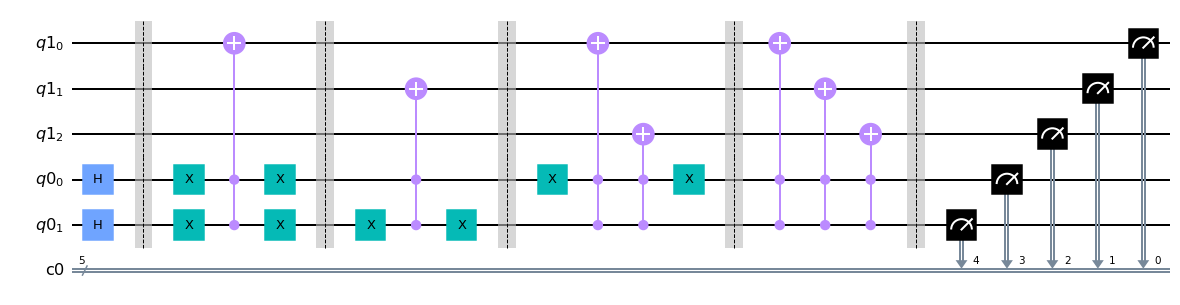

In [4]:
address = QuantumRegister(2)
data = QuantumRegister(3)
c = ClassicalRegister(5)
qc = QuantumCircuit(address,data,c)

# address preparation
qc.h([address[0],address[1]])
qc.barrier()
# address 0 -> data = 1
qc.x([address[0],address[1]])
qc.ccx(address[0],address[1],data[2])
qc.x([address[0],address[1]])
qc.barrier()
# address 1 -> data = 2
qc.x(address[0])
qc.ccx(address[0],address[1],data[1])
qc.x(address[0])
qc.barrier()
# address 2 -> data = 5
qc.x(address[1])
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[0])
qc.x(address[1])
qc.barrier()
# address 3 -> data = 7
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[1])
qc.ccx(address[0],address[1],data[0])
qc.barrier()


#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
for string, counts in dict(sorted(count.items())).items():
    print(f"{string[:2]}_{string[2:]}: {counts}")

qc.draw(output='mpl')

In [5]:
def qRAM_example(address_size, data_size):
    address = QuantumRegister(address_size)
    data = QuantumRegister(data_size)
    qc = QuantumCircuit(address, data)

    # address 0 -> data = 1
    qc.x([address[0],address[1]])
    qc.ccx(address[0],address[1],data[2])
    qc.x([address[0],address[1]])

    # address 1 -> data = 2
    qc.x(address[0])
    qc.ccx(address[0],address[1],data[1])
    qc.x(address[0])
    
    # address 2 -> data = 5
    qc.x(address[1])
    qc.ccx(address[0],address[1],data[2])
    qc.ccx(address[0],address[1],data[0])
    qc.x(address[1])

    # address 3 -> data = 7
    qc.ccx(address[0],address[1],data[2])
    qc.ccx(address[0],address[1],data[1])
    qc.ccx(address[0],address[1],data[0])

    
    qram = qc.to_gate()
    qram.name = "$qRAM$"
    return qram

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


00_001: 2008
01_010: 1989
10_101: 2039
11_111: 1964


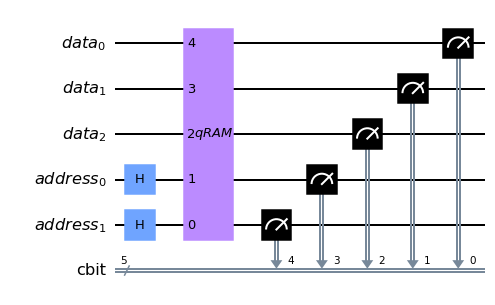

In [6]:
address = QuantumRegister(2, name="address")
data = QuantumRegister(3, name="data")
c = ClassicalRegister(5, name="cbit")

qc = QuantumCircuit(address, data, c)

qc.h(address)
qc.append(qRAM_example(2,3), address[:] + data[:])

#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
for string, counts in dict(sorted(count.items())).items():
    print(f"{string[:2]}_{string[2:]}: {counts}")

qc.draw(output='mpl')

In [7]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


11_000: 1000


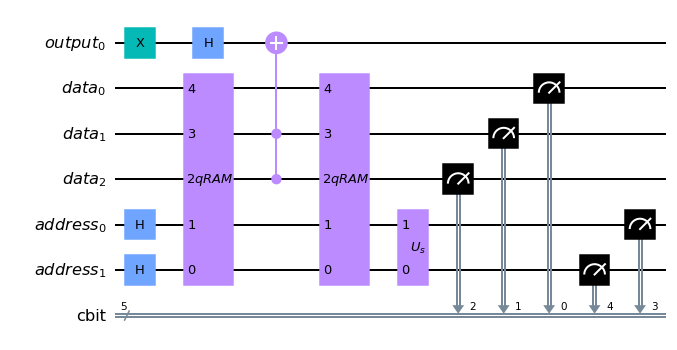

In [8]:
address = QuantumRegister(2, name="address")
data = QuantumRegister(3, name="data")
output = QuantumRegister(1, name="output")
c = ClassicalRegister(5, name="cbit")

qc = QuantumCircuit(address, data, output, c)
qram = qRAM_example(2, 3)

# Initialization
qc.h(address) # |++>

qc.x(output)
qc.h(output) # |->

#qc.h(data) # |++>

qc.append(qram, address[:] + data[:])

# Oracle
# qc.x([data[2],data[0]])
# qc.mct(data, output)
# qc.x([data[2],data[0]])
qc.ccx(data[0], data[1], output)

qc.append(qram, address[:] + data[:])

    
# Diffuser
qc.append(diffuser(2), address)

#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=1000, seed_simulator=12345, backend_options={"fusion_enable":True})

result = job.result()
count =result.get_counts()
for string, counts in dict(sorted(count.items())).items():
    print(f"{string[:2]}_{string[2:]}: {counts}")

qc.draw(output='mpl')

### qRAM Data Search
To perform Grover's algorithm, we invert the sign of the **address qubit** containing $m$. We also need to initialize the **data qubit** by another qRAM operation before the Diffusion operation,

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
where $f$ denotes the flag qubit.  

In this case, we can configure an oracle operation using the [C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate) . 

Here, we show the whole circuit for our [qRAM example](#qRAM-Example:-Find-the-data-from-qRAM).

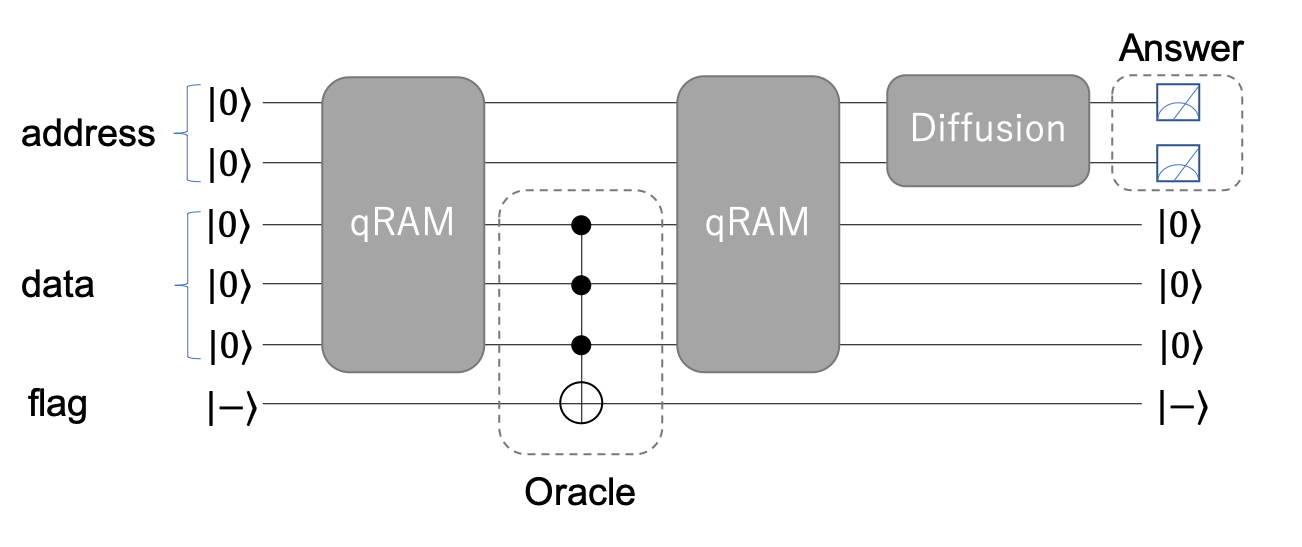

In [6]:
Image('circuit_ex.png')

### Considerations for qRAM implementation
In the above description we have introduced a naive *qRAM operation* circuit.
Depending on the data structure, we can simplify the circuit by using **gate synthesis** (equivalence transformation) techniques.
Also, some simplified gates, e.g. [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate), may help improve your *CNOT*-saving implementation.

An example of gate synthesis is shown below.

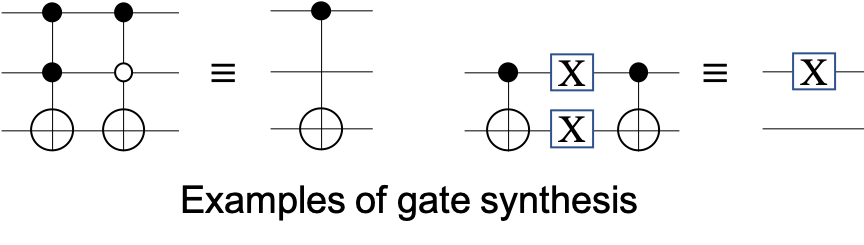

In [7]:
Image('gatesynthesis_ex.png')

## Learning Exercise II-B
Let's solve a 4-Lights Out problem with qRAM.  

When the initial board state lightsout4=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\] is described by the following data, 
determine the _binary_ number of the solvable boards in $3$ switch operations.  (ex. Board 0 → 00, 1 → 01, 2 → 10, 3 → 11)

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure only the `solution` (2bit) that solves the puzzle.

To submit your solution, create a function which takes "lightsout4" as an input and returns `QuantumCircuit`.  You can choose a function name you like. Make sure it works even if you input another dataset to "lightsout4".

 **In addition, please implement the quantum circuit within 28 qubits.**

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

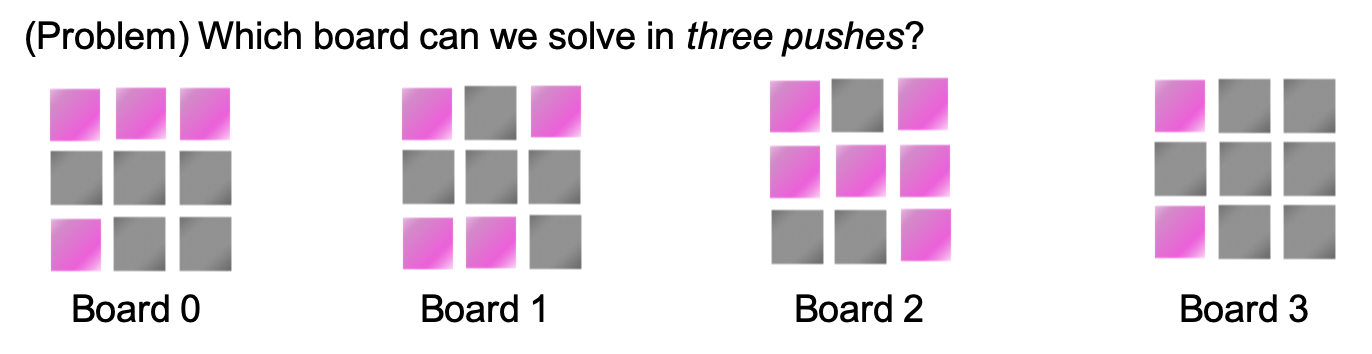

In [8]:
Image('4lightsout_pr.png')

# Solution
While the previous exercises were all rather straighforward to solve, Exercise II-b is actually the first exercise that is non-trivial to solve within the given limitations.

We can break down the solution in to following subproblems:

1. Store the 4 different boards in the qRAM (as efficient as possible)
2. Solve the boards
3. Count the number of pushes needed in each solution
4. Return the index of the only 3-solvable boards by measuring the address qubits

Before going through each of the steps individually, let's quickly estimate the amount of qubits and quantum registers we need:

1. qRAM, to store the board configurations
    - 2 Address Qubits 
    - 9 Lights/Board Qubits
2. Switches/Solution
    - 9 Qubits 
3. Output Qubit for the Grover oracle
    - 1 Qubit
... amounting to a total of 21 Qubits so far, leaving us with
4. Ancilla Qubits
    - 7 Qubits
that need to be used to implement the push counter and speed up Multicontrol (MCT) gates.

The overall structure of the solution will use a nested Grover approach as follows:
1. State initialization, including writing the boards to the qRAM
2. Outer Grover loop for amplication of the correct address
    1. Inner Grover loop for amplification of the solution to the boards in the qRAM (Oracle from previous exercise is reusable)
    2. Oracle with counter to identify 3-push solutions
    3. Uncomputation of A.
    4. Uncomputation of qRAM
3. Measurement

## 1. Board qRAM
Writing the boards into the qRam works exactly like the example provided in the introduction of the exercise: 
The address qubits are placed in a uniform superposition while the qubits in the lights register are set according to their desired states via (multi-)controlled X gates controlled by the address qubits.

In order to use as few gates as possible we do not start with the board register being all zeros (or ones, like in the last exercise) but instead chosse an initial state that has the closest *Hamming* distance to all configuration that need to be stored in the qRAM.

This is done be the function ```find_closest_string``` below. As a remark, please not that this problem of finding the closest binary vector is actually NP-hard and hence a better approach would probably be using Grey Codes, however for the problem size in this exercise the naive implementation below is sufficient.

In [10]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

In [11]:
from scipy.spatial import distance
for i in range(4):
    for j in range(i + 1, 4):
        dist = distance.hamming(lightsout4[i], lightsout4[j])
        print(f"Distance {i}<-->{j}: {dist}")

Distance 0<-->1: 0.2222222222222222
Distance 0<-->2: 0.6666666666666666
Distance 0<-->3: 0.2222222222222222
Distance 1<-->2: 0.6666666666666666
Distance 1<-->3: 0.2222222222222222
Distance 2<-->3: 0.6666666666666666


In [12]:
def find_closest_string(strings):
    length = len(strings[0])
    min_dist = 1000
    min_string = None
    
    for i in range(int(2 ** length)):
        bits = [int(a) for a in format(i,'09b')]
        dist = sum([distance.hamming(bits, s) for s in strings])
        if dist < min_dist:
            min_dist = dist
            min_string = bits
        
    return min_string, min_dist

closest_string, closest_dist = find_closest_string(lightsout4)
print(closest_string, closest_dist)

[1, 0, 1, 0, 0, 0, 1, 0, 0] 0.8888888888888888


We can see that ```[1, 0, 1, 0, 0, 0, 1, 0, 0]``` has the smallest average hamming distance to the other vectors in the board configuration ```lightsout4```. As in the previous exercise, we invert the vector and set the initial state of the board quantum register accordingly:

In [13]:
def init_light_states(qc, lights, light_qubits):
    for i, light in enumerate(lights):
        if light == 0:
            qc.x(light_qubits[i])

Next, the boards are written into the qRAM by computing for each board configuration which qubits need to be flipped to go from the initial state ```[1, 0, 1, 0, 0, 0, 1, 0, 0]``` to the desired configuration.

This is done by the line ```switches = np.equal(board, closest_lights)```.

Furthermore, to decrease the number of CNOTs in the transpiled circuit, we use RCCX gates instead of CCX/Toffoli gates here to entangle the address qubits with the board register. As shown in the first exercise, RCCX will be transpiled into 3 CNOT gates while Toffoli usually need 6 CNOT gates. The RCCX produces the same result as the Toffoli up to differences in phase. 

Here, this difference does not matter since the qRAM is *uncomputed* after the oracle anyway.

In [15]:
def qRAM(address_size, data_size, lights):
    import numpy as np
    
    address_qubits = QuantumRegister(address_size)
    data_qubits = QuantumRegister(data_size)
    qc = QuantumCircuit(address_qubits, data_qubits)
    
    closest_lights, _ = find_closest_string(lights)     
    init_light_states(qc, closest_lights, data_qubits)

    for n, board in enumerate(lights):
        for ab, bit in enumerate(format(n,'02b')):
            if bit == '0':
                qc.x(address_qubits[ab])

        switches = np.equal(board, closest_lights)

        for db, switch in enumerate(switches):
            if switch == False:
                qc.rccx(address_qubits[0], address_qubits[1], data_qubits[db])

        for ab, bit in enumerate(format(n,'02b')):
            if bit == '0':
                qc.x(address_qubits[ab])

    qram = qc.to_gate()
    qram.name = "$qRAM$"
    return qram

### Test Case 1: qRAM write and measure 
To conclude the first subproblem we test our qRAM by measuring the contenten of the address and board registers after the qRAM was written.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


00_000111011: 2008
01_010111001: 1989
10_010000110: 2039
11_011111011: 1964
   000111011
   010111001
   010000110
   011111011


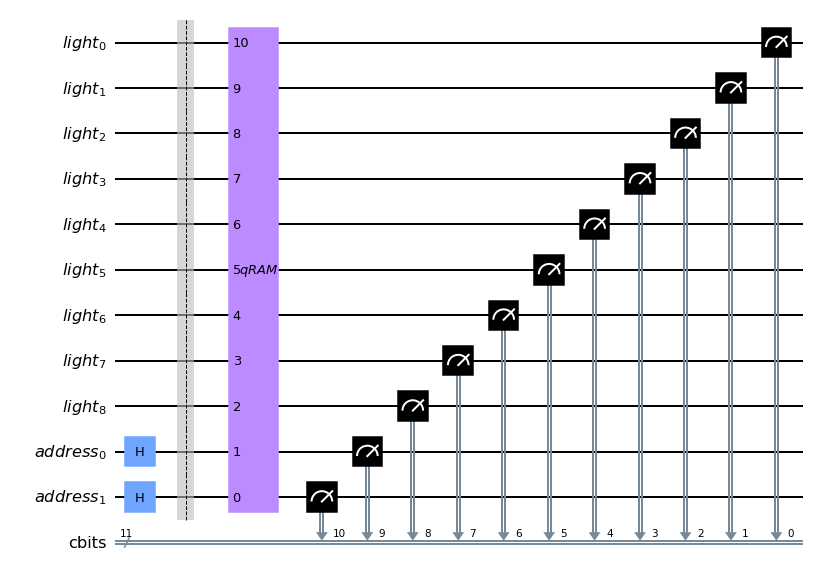

In [15]:
# Create separate registers to name bits
address_qubits = QuantumRegister(2, name='address')
light_qubits = QuantumRegister(9, name='light')
cbits = ClassicalRegister(11, name="cbits")
qc = QuantumCircuit(address_qubits, light_qubits, cbits)

# address preparation
qc.h([address_qubits[0],address_qubits[1]])
qc.barrier()

qc.append(qRAM(2, 9, lightsout4), address_qubits[:] + light_qubits[:])

#Check the qRAM　status
qc.measure(address_qubits, cbits[0:2])
qc.measure(light_qubits, cbits[2:11])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count = result.get_counts()
for string, counts in dict(sorted(count.items())).items():
    print(f"{string[:2]}_{string[2:]}: {counts}")

for lights in lightsout4:
    print("   "+"".join([f'{abs(c-1)}' for c in lights]))
    
qc.draw(output='mpl')

Comparing these measurement results
```
00_000111011: 2008
01_010111001: 1989
10_010000110: 2039
11_011111011: 1964
```
with the ground truth result obtained from the ```lightsout4``` vector
```
000111011
010111001
010000110
011111011,
```

we can indeed observe that only the specified configurations could be measured and in addition to that measured approximately equally often: 

Our qRAM contains now a uniform superposition of the board configurations.

### Test Case 2: qRAM read with trivial oracle
Finally, before proceeding to the next step, we test how the qRAM works with a very simple oracle, namely the which checks if the 7th Qubit is *not* set. Furthermore, like it is supposed to be done for the exercise, we only measure the address qubits in the end (since the qRAM is uncomputed after the oracle we could only measure the intitial state of the board qubits). As we can see in the measurement output above we expect the measurement result to be ```01```.

This code which performs this is shown below. 

**Remark**: To be precise, we actually check if the 7th Qubit is set and hence all other address qubits `00, 10, 11` will acquire the (-1) phase factor while the ground truth ```01``` will not. Nevertheless, since the resulting state only differs from the one with the sign of all the phase factors flipped by a global phase (of again -1), this is irrelevant from the perspective of Grover's algorithm.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


01_: 1000


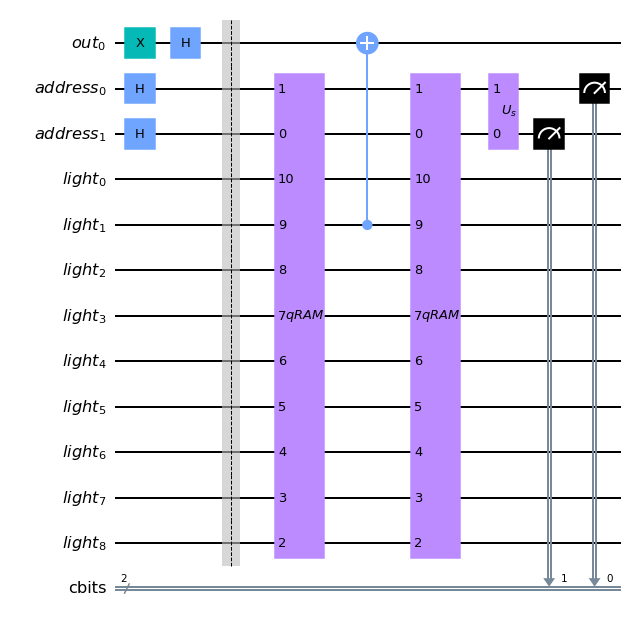

In [22]:
light_qubits = QuantumRegister(9, name='light')
address_qubits = QuantumRegister(2, name='address')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(2, name="cbits")
qc = QuantumCircuit(light_qubits, address_qubits, output_qubit, cbits)

# Initialization
# Flag to |->
qc.x(output_qubit)
qc.h(output_qubit)

# Address to |++>
qc.h([address_qubits[0],address_qubits[1]])
qc.barrier()

qc.append(qRAM(2, 9, lightsout4), address_qubits[:] + light_qubits[:])
qc.cx(light_qubits[7], output_qubit)
qc.append(qRAM(2, 9, lightsout4), address_qubits[:] + light_qubits[:])
    
# Diffuser
qc.append(diffuser(2), address_qubits)

#Check the qRAM　status
qc.measure(address[0:2], cbits[0:2])
#qc.measure(light_qubits, cbits[2:11])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=1000, seed_simulator=12345, backend_options={"fusion_enable":True})

result = job.result()
count =result.get_counts()
for string, counts in dict(sorted(count.items())).items():
    print(f"{string[:2]}_{string[2:]}: {counts}")

qc.draw(output='mpl')

As expected we get 1000/1000 Counts for the address ```01```.

### 2. Solving the boards

The solution of the boards works exactly like in the previous exercise. The only difference is that instead of working with a single classical configuration stored inside the board register, they now contain a superposition entangled with the address qubits register.

The oracle is therefore exactly the same and Grover's algorithm will consequently produce a superposition of solutions in the switches quantum register.

The code following below is therefore very similar to the previous exercise, however, I refactored and streamlined it to basically allow for arbitrary sized (square) boards. The motivation for this was not only cleaner code but also the possibility to solve the problem with a smaller problem size (e.g. 2x2 boards). This halves the number of needed qubits from 28 to 14 and allows for much faster run and debug cycles.

**Auxiliary functions to compute optimal initial states and next neighbor edges for square boards**

In [24]:
def find_closest_string(strings):
    
    from scipy.spatial import distance

    length = len(strings[0])
    min_dist = 1000
    min_string = None

    for i in range(int(2 ** length)):
        bits = [int(a) for a in format(i, f"0{length}b")]
        dist = sum([distance.hamming(bits, s) for s in strings])
        if dist < min_dist:
            min_dist = dist
            min_string = bits

    return min_string, min_dist


def compute_switch_edges(board_size=3):

    coord2num = lambda i, j: board_size * i + j
    edges = {}

    for i in range(board_size):
        for j in range(board_size):
            e = {
                coord2num(i, j),
                coord2num(max(0, i - 1), j),
                coord2num(min(board_size - 1, i + 1), j),
                coord2num(i, max(0, j - 1)),
                coord2num(i, min(board_size - 1, j + 1))
                }
            edges[coord2num(i, j)] = sorted(list(e))

    return edges

**Generic diffuser, usable with or without ancilla qubits**

In [17]:
def diffuser(qc, diffusion_qubits, ancilla_qubits=None):

    if ancilla_qubits is not None:
        assert len(ancilla_qubits) >= len(diffusion_qubits) - 2

    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(diffusion_qubits)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(diffusion_qubits)

    # Do multi-controlled-Z gate
    qc.h(diffusion_qubits[-1])

    if ancilla_qubits is not None:
        qc.mct(diffusion_qubits[:-1], diffusion_qubits[-1], ancilla_qubits, mode='basic')
    else:
        qc.mct(diffusion_qubits[:-1], diffusion_qubits[-1])

    qc.h(diffusion_qubits[-1])

    # Apply transformation |11..1> -> |00..0>
    qc.x(diffusion_qubits)
    # Apply transformation |00..0> -> |s>
    qc.h(diffusion_qubits)
    # We will return the diffuser as a gate


def diffuser_gate(nqubits, use_ancillas=False):
    diffusion_qubits = QuantumRegister(nqubits, name='out')

    if use_ancillas:
        ancilla_qubits = QuantumRegister(nqubits - 2, name='ancilla')
        qc = QuantumCircuit(diffusion_qubits, ancilla_qubits)
    else:
        ancilla_qubits = None
        qc = QuantumCircuit(diffusion_qubits)

    diffuser(qc, diffusion_qubits, ancilla_qubits)

    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

**The qRAM write procedure already shown above**

In [18]:
def write_qram(lights, qc, address_qubits, data_qubits):
    
    import numpy as np
    
    closest_lights, _ = find_closest_string(lights)
    init_light_states(qc, closest_lights, data_qubits)

    for n, board in enumerate(lights):
        for ab, bit in enumerate(format(n,'02b')):
            if bit == '0':
                qc.x(address_qubits[ab])

        switches = np.equal(board, closest_lights)

        for db, switch in enumerate(switches):
            if not switch:
                qc.rccx(address_qubits[0], address_qubits[1], data_qubits[db])

        for ab, bit in enumerate(format(n,'02b')):
            if bit == '0':
                qc.x(address_qubits[ab])

**The oracle circuit already used in the previous exercise for arbitray board size and optional ancilla usage** 

In [19]:
def lights_out_oracle(qc, switch_qubits, light_qubits, output_qubit, ancilla_qubits=None):
    import numpy as np

    num_lights = len(switch_qubits)

    if ancilla_qubits is not None:
        assert len(ancilla_qubits) >= len(switch_qubits) - 2

    edges = compute_switch_edges(int(np.sqrt(num_lights)))

    # Connect Switches to lights
    for source, targets in edges.items():
        for target in targets:
            qc.cx(switch_qubits[source], light_qubits[target])

    if ancilla_qubits is not None:
        qc.mct(light_qubits, output_qubit, ancilla_qubits, mode='basic')
    else:
        qc.mct(light_qubits, output_qubit)

    # Uncompute
    for source, targets in edges.items():
        for target in targets:
            qc.cx(switch_qubits[source], light_qubits[target])


def lights_out_oracle_gate(use_ancillas=False, num_lights=9):

    switch_qubits = QuantumRegister(num_lights, name='switch')
    light_qubits = QuantumRegister(num_lights, name='light')
    output_qubit = QuantumRegister(1, name='out')

    if use_ancillas:
        ancilla_qubits = QuantumRegister(num_lights - 2, name='ancilla')
        qc = QuantumCircuit(switch_qubits, light_qubits, output_qubit, ancilla_qubits)
    else:
        ancilla_qubits = None
        qc = QuantumCircuit(switch_qubits, light_qubits, output_qubit)

    lights_out_oracle(qc, switch_qubits, light_qubits, output_qubit, ancilla_qubits)

    oracle = qc.to_gate()
    oracle.name = "$O_{2a}$"

    return oracle

## 3. Push Counter
To identify which board is solvable within 3 pushes we just need to take a look at the 9 qubit solution vector, stored in the switch register and count the number of qubits set to 1. Hence, we basically need to implement a quantum version of `popcnt`, i.e. a quantum counter circuit using the reversible version of classical logic gates **within the limit of 7 available ancilla qubits**. 

The easiest way to implement this would be to just use the ```WeightedAdder``` class from the Qiskit Circuit Library. Unfortunately, this circuit requires 8 ancilla qubits which only leaves the option of implementing the counter ourselves.

To that end, we can use the half and full adder circuits implemented in the first exercise and create a custom counter. In order to save qubits we need to overwrite some of the input qubits with the result qubits. In particular, the ```Cin```(Carry-In) will be overwritten with the ``Sum`` output of the full adder. This is shown in the figure below. Please note that the unlabeled input wire will be a $|0\rangle$-initialized ancilla qubit.

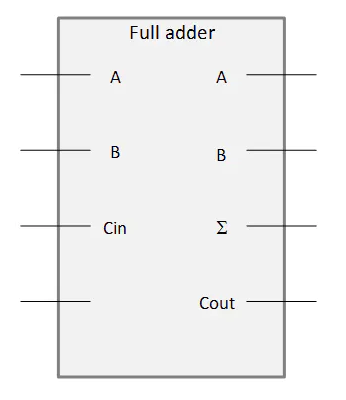

In [6]:
from IPython.display import Image, display
Image("figures/fulladder.png", width="200")

Each full adder can be used to add 3 1-bit inputs and consequently we will divide the 9 switch qubits into groups of three and apply one full adder to each group. As noted before, this will alter some of the switch qubits, which is, however, irrelevant since the counter circuit will be uncomputed after the oracle applies the phase factor.

After this, we have three ```Cout``` Ouputs worth $2^1=2$ and three ```Sum``` outputs worth $2^0=1$ to which we again apply another full adder circuit each. Now we 4 outputs representing 4, 2, 2, 1 which we finally combine with two half adders to arrive at a final 4 bit result (able to store counts from 0 to 9).

The full layout is depicted in the following figure.

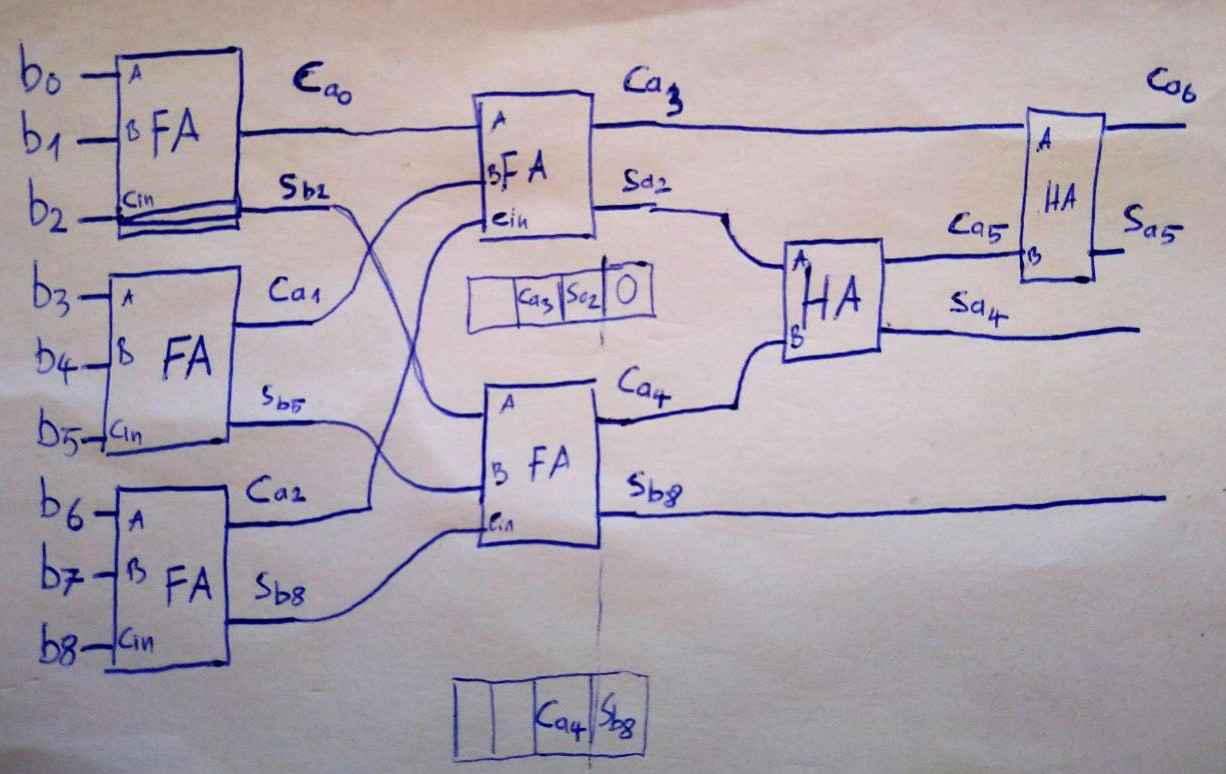

In [8]:
from IPython.display import Image, display
Image("figures/9QubitCounter.jpg", width="800")

In this drawing the inputs (the 9 switch qubits) are denoted $b_0,\ldots,b_8$, carry-out and sum outputs by $C_q$ and $S_q$, respectively. The indices $q$ indicate if a fresh ancilla $a_i$ was used to store the output or if input $b_j$ was overwritten to store the output.

The final result of the counter is then given by (from most signifcant to least significant bit):

$$C_{a_6}S_{a_5}S_{a_4}S_{b_8}$$

Looking at the indices of the ancilla qubits with the highest being $a_6$ we indeed managed to stay within the 7 ancilla qubits limit.

This concept translates to code as shown belows. Here, we also make use of converting the quantum circuit to a custom gate. The reasons for this is that the counter code need to be uncomputed again, which is extremly simplified by the fact that gate objects bring there own ```.inverse()``` method for uncomputation.

In [20]:
def replace_op_half_adder():
    q = QuantumRegister(2, name='operands')
    res = QuantumRegister(1, name='results')
    qc = QuantumCircuit(q, res)

    # CarryOut
    qc.ccx(q[0], q[1], res[0])

    # SUM
    qc.cx(q[0], q[1])

    gate = qc.to_gate()
    gate.name = "HAro"

    return gate

def replace_carry_full_adder():
    q = QuantumRegister(4, name='operands')
    qc = QuantumCircuit(q)

    qc.ccx(q[0], q[1], q[3])
    qc.cx(q[0], q[1])
    qc.ccx(q[1], q[2], q[3])
    qc.cx(q[1], q[2])
    qc.cx(q[0], q[1])

    gate = qc.to_gate()
    gate.name = "FArc"

    return gate

def counter_9bit_gate():
    op_qubits = QuantumRegister(9, name='operands')
    ancilla_qubits = QuantumRegister(7, name='ancilla')

    qc = QuantumCircuit(op_qubits, ancilla_qubits)

    qc.append(replace_carry_full_adder(), op_qubits[:3] + [ancilla_qubits[0]])
    qc.append(replace_carry_full_adder(), op_qubits[3:6] + [ancilla_qubits[1]])
    qc.append(replace_carry_full_adder(), op_qubits[6:] + [ancilla_qubits[2]])

    qc.append(replace_carry_full_adder(), ancilla_qubits[:3] + [ancilla_qubits[3]])
    qc.append(replace_carry_full_adder(), [op_qubits[2], op_qubits[5], op_qubits[8], ancilla_qubits[4]])

    qc.append(replace_op_half_adder(), [ancilla_qubits[2], ancilla_qubits[4], ancilla_qubits[5]])
    qc.append(replace_op_half_adder(), [ancilla_qubits[3], ancilla_qubits[5], ancilla_qubits[6]])

    qc.swap(ancilla_qubits[3], op_qubits[8])

    counter = qc.to_gate()
    counter.name = "Counter"

    return counter

## 4. Finding the address of the 3-solvable board

Given the result of the counter all that remains to do is perform the core oracle operation that applies the phase factor using the output qubit and then putting everything together.

The condition to be solvable within 3 pushes translates to checking that the two most significant bits of the counter output (worth $2^3=8$ and $2^2=4$) are zeros (If we were looking for *exactly* 3 pushes, additionally the two LSB need to be ones). This implies just a simple CCX gate controlled by the flipped ancilla qubits $a_6$ and $a_5$:

``` python
    qc.x(ancilla_qubits[5:])
    qc.ccx(ancilla_qubits[5], ancilla_qubits[6], output_qubit)
    qc.x(ancilla_qubits[5:])
```

The rest of the circuit, as shown below, then follows the structure already described in beginning of this solution write-up

In [25]:
def week2b_ans_func(lights):
    num_iterations=5
    
    switch_qubits = QuantumRegister(9, name='switch')
    light_qubits = QuantumRegister(9, name='light')
    address_qubits = QuantumRegister(2, name='address')
    ancilla_qubits = QuantumRegister(7, name='ancilla')
    output_qubit = QuantumRegister(1, name='out')
    cbits = ClassicalRegister(2, name="cbits")
    qc = QuantumCircuit(switch_qubits, light_qubits, address_qubits, ancilla_qubits, output_qubit, cbits)

    # Initialization
    # Flag to |->
    qc.x(output_qubit)
    qc.h(output_qubit)

    # Address to |++>
    qc.h(address_qubits)

    # Switch to |+++++++++>
    qc.h(switch_qubits)
    qc.barrier()

    write_qram(lights, qc, address_qubits, light_qubits)
    qc.barrier()

    for i in range(num_iterations):
        lights_out_oracle(qc, switch_qubits, light_qubits, output_qubit, ancilla_qubits)
        diffuser(qc, switch_qubits, ancilla_qubits)
    qc.barrier()

    # Counter
    qc.append(counter_9bit_gate(), switch_qubits[:] + ancilla_qubits[:])

    # Select Solutions with only one switch, 2 MSB set to 0
    qc.x(ancilla_qubits[5:])
    qc.ccx(ancilla_qubits[5], ancilla_qubits[6], output_qubit)
    qc.x(ancilla_qubits[5:])

    qc.append(counter_9bit_gate().inverse(), switch_qubits[:] + ancilla_qubits[:])

    for i in range(num_iterations):
        lights_out_oracle(qc, switch_qubits, light_qubits, output_qubit, ancilla_qubits)
        diffuser(qc, switch_qubits, ancilla_qubits)
    qc.barrier()

    write_qram(lights, qc, address_qubits, light_qubits)
    diffuser(qc, address_qubits)

    qc.barrier()
    qc.measure(address_qubits, cbits)

    qc = qc.reverse_bits()

    return qc

In [22]:
#qc = week2b_ans_func(lightsout4)
#qc.draw()

In [26]:
# Submission code
from qc_grader import prepare_ex2b, grade_ex2b, submit_ex2b

# Execute your circuit with following prepare_ex2b() function.
# The prepare_ex2b() function works like the execute() function with only QuantumCircuit as an argument.
job  =  prepare_ex2b(week2b_ans_func)

result = job.result()
count = result.get_counts()
original_problem_set_counts = count[0]

original_problem_set_counts
# The bit string with the highest number of observations is treated as the solution.

Running week2b_ans_func...
Computing cost...
Starting experiments. Please wait...
You may monitor the job (id: 5fb92b404d16d6001eff3b76) status and proceed to grading when it successfully completes.


{'00': 2052, '01': 1760, '10': 2105, '11': 2083}

In [22]:
# Check your answer by executing following code.
# The quantum cost of the QuantumCircuit is obtained as the score. The quantum cost is related to rank only in the third week.
grade_ex2b(job)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 63014.
Feel free to submit your answer.


In [23]:
# Submit your results by executing following code. You can submit as many times as you like during the period. 
submit_ex2b(job)

Submitting your answer. Please wait...

Success 🎉! Your answer has been submitted.
There seems to be huge "noise clusters" interfering with Dr. Ryoko’s device. Can you please help?
